### Train best model according to report to try to reproduce results

- All static features: 
    * Z500, 
    * T850, 
    * latitude, 
    * orography, 
    * land-sea mask, 
    * soil type, and 
    * top-of-atmosphere radiation
- L=2
- $\Delta t$ = 6

#### Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/'.join(sys.path[0].split('/')[:-1]))

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import healpy as hp
import random

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from modules.utils import train_model_2steps_temp, init_device
from modules.data import WeatherBenchDatasetXarrayHealpixTemp
from modules.healpix_models import UNetSphericalHealpix, UNetSphericalTempHealpix
from modules.test import create_iterative_predictions_healpix_temp, compute_rmse_healpix
from modules.plotting import plot_rmses

datadir = "../data/healpix/"
input_dir = datadir + "5.625deg_nearest/"
model_save_path = datadir + "models/"
pred_save_path = datadir + "predictions/"

if not os.path.isdir(model_save_path):
    os.mkdir(model_save_path)
    
if not os.path.isdir(pred_save_path):
    os.mkdir(pred_save_path)

In [3]:
import warnings
warnings.filterwarnings("ignore")

Define constants and load data

In [4]:
chunk_size = 521#483*2 #483

In [5]:
from modules.data import WeatherBenchDatasetIterative
class WeatherBenchDatasetXarrayHealpixTemp(Dataset):
    
    """ Dataset used for graph models (1D), where data is loaded from stored numpy arrays.
    
    Parameters
    ----------
    ds : xarray Dataset
        Dataset containing the input data
    out_features : int
        Number of output features
    delta_t : int
        Temporal spacing between samples in temporal sequence (in hours)
    len_sqce : int
        Length of the input and output (predicted) sequences
    years : tuple(str)
        Years used to split the data
    nodes : float
        Number of nodes each sample has
    max_lead_time : int
        Maximum lead time (in case of iterative predictions) in hours
    load : bool
        If true, load dataset to RAM
    mean : np.ndarray of shape 2
        Mean to use for data normalization. If None, mean is computed from data
    std : np.ndarray of shape 2
        std to use for data normalization. If None, mean is computed from data
    """
        
    def __init__(self, ds, out_features, delta_t, len_sqce, years, nodes, nb_timesteps, 
                 max_lead_time=None, load=True, mean=None, std=None):
        
        
        self.delta_t = delta_t
        self.len_sqce = len_sqce
        self.years = years
        
        self.nodes = nodes
        self.out_features = out_features
        self.max_lead_time = max_lead_time
        self.nb_timesteps = nb_timesteps
        
        self.data = ds.to_array(dim='level', name='Dataset').transpose('time', 'node', 'level')
        self.in_features = self.data.shape[-1]
        
        self.mean = self.data.mean(('time', 'node')).compute() if mean is None else mean
        self.std = self.data.std(('time', 'node')).compute() if std is None else std
        
        eps = 0.001 #add to std to avoid division by 0
        
        # Count total number of samples
        total_samples = self.data.shape[0]        
        
        if max_lead_time is None:
            self.n_samples = total_samples - (len_sqce+1) * delta_t
        else:
            self.n_samples = total_samples - (len_sqce+1) * delta_t - max_lead_time
        
        # Normalize
        self.data = (self.data - self.mean.to_array(dim='level')) / (self.std.to_array(dim='level') + eps)
        self.data.persist()
        
        self.idxs = np.array(range(self.n_samples))
        
        print('Loading data to RAM...')
        t = time.time()
        self.data.load()
        print('Time: {:.2f}s'.format(time.time() - t))
        
        
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx):
        """ Returns sample and label corresponding to an index as torch.Tensor objects
            The return tensor shapes are (for the sample and the label): [n_vertex, len_sqce, n_features]
            
        """
        idx_data = idx#self.idxs[idx]
        #1,0,2
        
        #batch[0] --> (batch_size, num_nodes, n_features*len_sq)
        idx_full = np.concatenate(np.array([[idx_data+self.delta_t*k] for k in range(self.len_sqce+2)]).reshape(-1,1)) # ex: len_sqce=2 --> we need 0,1,2,3
        #idx_full = np.concatenate([idx_data+delta_t,  idx_data + delta_t * len_sqce, idx_data + delta_t * (len_sqce+1)])
        dat = self.data.isel(time=idx_full).values
        
        
        X = (
            torch.tensor(dat[:len(idx)*self.len_sqce,:,:] , \
                         dtype=torch.float).reshape(len(idx)*self.len_sqce, self.nodes, -1),
        )
        
        y = (torch.tensor(dat[len(idx):len(idx)*(self.len_sqce+1),:,:],\
                         dtype=torch.float).reshape(len(idx)*self.len_sqce, self.nodes, -1),\
             torch.tensor(dat[len(idx)*(self.len_sqce):,:,:out_features],\
                         dtype=torch.float).reshape(len(idx)*self.len_sqce, self.nodes, -1)
        
        )
        return X, y 

In [6]:
def train_model_2steps(model, device, training_ds, constants, batch_size, epochs, lr, validation_ds):    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, eps=1e-7, weight_decay=0, amsgrad=False)
    
    train_losses = []
    val_losses = []
    n_samples = training_ds.n_samples
    n_samples_val = validation_ds.n_samples
    num_nodes = training_ds.nodes
    num_constants = constants.shape[1]
    out_features = training_ds.out_features
    
    constants_expanded = constants.expand(batch_size, num_nodes, num_constants)
    constants1 = constants_expanded.to(device)
    idxs_val = validation_ds.idxs
    
    for epoch in range(epochs):
        
        print('\rEpoch : {}'.format(epoch), end="")
        
        time1 = time.time()
        
        val_loss = 0
        train_loss = 0
        
        model.train()  
        
        random.shuffle(training_ds.idxs)
        idxs = training_ds.idxs
        
        batch_idx = 0
        
        for i in range(0, n_samples - batch_size, batch_size):
            i_next = min(i + batch_size, n_samples)
            
            if len(idxs[i:i_next]) < batch_size:
                constants_expanded = contants.expand(len(idxs[i:i_next]), num_nodes, num_constants)
                constants1 = constants_expanded.to(device)
        
            
            #t1 = time.time()
            batch, labels = training_ds[idxs[i:i_next]]
            
            #t2 = time.time()
            
            # Transfer to GPU
            batch_size = batch[0].shape[0]//2
            
            batch1 = torch.cat((batch[0][:batch_size, :,:], \
                                constants_expanded,batch[0][batch_size:, :,:] ,constants_expanded), dim=2).to(device)
            #batch1 = torch.cat((batch[0], constants_expanded), dim=2).to(device)
            
            label1 = labels[0].to(device)
            label2 = labels[1].to(device)
            
            #t3 = time.time()
            batch_size = batch1.shape[0]
            
            # Model
            
            #t4 = time.time()
            output1 = model(batch1)  
            #t5 = time.time()
            # [z_tdelta1, t_tdelta1, toa_tdelta1, constants, z_tdelta2, t_tdelta2, toa_tdelta2, constants]
            toa_delta = batch[0][batch_size:, :,-1].view(-1, num_nodes, 1).to(device)
            batch2 = torch.cat((output1, toa_delta, constants1, \
                               label1[batch_size:, :,:], constants1), dim=2)
            
            #batch2 = torch.cat((output1, label1[:,:,-1].view(-1, num_nodes, 1), constants1), dim=2)
            #t6 = time.time()
            output2 = model(batch2)
            #t7 = time.time()
            loss = criterion(output1, label1[batch_size:,:,:out_features]) + criterion(output2, label2[batch_size:,:,:out_features])
            #t8 = time.time()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss = train_loss + loss.item() * batch_size
            
            
            #print('\nTime to read batch: {}s'.format(t2-t1))
            #print('Time to transfer data to GPU: {}s'.format(t3-t2))
            #print('Time to process input 1: {}s'.format(t5-t4))
            #print('Time to process input 2: {}s'.format(t7-t6))
            #print('Time to compute loss: {}s'.format(t8-t7))
            #print('\n')
            if batch_idx%50 == 0:
                print('\rBatch idx: {}; Loss: {:.3f}'.format(batch_idx, train_loss/(batch_size*(batch_idx+1))), end="")
            batch_idx += 1
        
        train_loss = train_loss / n_samples
        train_losses.append(train_loss)
        
        model.eval()
        
        constants1 = constants_expanded.to(device)
        with torch.set_grad_enabled(False):
            index = 0
            
            for i in range(0, n_samples_val - batch_size, batch_size):
                i_next = min(i + batch_size, n_samples_val)

                if len(idxs_val[i:i_next]) < batch_size:
                    constants_expanded = contants.expand(len(idxs_val[i:i_next]), num_nodes, num_constants)
                    constants1 = constants_expanded.to(device)


                #t1 = time.time()
                batch, labels = validation_ds[idxs_val[i:i_next]]
                # Transfer to GPU
                batch_size = batch[0].shape[0]//2
            
                batch1 = torch.cat((batch[0][:batch_size, :,:], \
                                    constants_expanded,batch[0][batch_size:, :,:] ,constants_expanded), dim=2).to(device)
                label1 = labels[0].to(device)
                label2 = labels[1].to(device)

                batch_size = batch1.shape[0]

                output1 = model(batch1)  
                toa_delta = batch[0][batch_size:, :,-1].view(-1, num_nodes, 1).to(device)
                batch2 = torch.cat((output1, toa_delta, constants1, \
                                   label1[batch_size:, :,:], constants1), dim=2)
                output2 = model(batch2)
                
                val_loss = val_loss + (criterion(output1, label1[batch_size:,:,:out_features]).item() 
                                       + criterion(output2, label2[batch_size:,:,:out_features]).item()) * batch_size
                index = index + batch_size
                
        val_loss = val_loss / n_samples_val
        val_losses.append(val_loss)
        
        time2 = time.time()
        
        # Print stuff
        print('Epoch: {e:3d}/{n_e:3d}  - loss: {l:.3f}  - val_loss: {v_l:.5f}  - time: {t:2f}'
              .format(e=epoch+1, n_e=epochs, l=train_loss, v_l=val_loss, t=time2-time1))
        
    return train_losses, val_losses

In [7]:
z500 = xr.open_mfdataset(f'{input_dir}geopotential_500/*.nc', combine='by_coords', chunks={'time':chunk_size}).rename({'z':'z500'})
t850 = xr.open_mfdataset(f'{input_dir}temperature_850/*.nc', combine='by_coords', chunks={'time':chunk_size}).rename({'t':'t850'})
rad = xr.open_mfdataset(f'{input_dir}toa_incident_solar_radiation/*.nc', combine='by_coords', chunks={'time':chunk_size})

z500 = z500.isel(time=slice(7, None))
t850 = t850.isel(time=slice(7, None))

constants = xr.open_dataset(f'{input_dir}constants/constants_5.625deg_standardized.nc')

orog = constants['orog']
lsm = constants['lsm']
lats = constants['lat2d']
slt = constants['slt']
cos_lon = constants['cos_lon']
sin_lon = constants['sin_lon']

num_constants = len([orog, lats, lsm, slt])
constants_tensor = torch.tensor(xr.merge([orog, lats, lsm, slt], compat='override').to_array().values, \
                            dtype=torch.float)

In [8]:
train_mean_ = xr.open_mfdataset(f'{input_dir}mean_train_features_dynamic.nc')
train_std_ = xr.open_mfdataset(f'{input_dir}std_train_features_dynamic.nc')

### Use 5 years of data

In [9]:
train_years = ('2007', '2012')#('1979', '2012')
val_years = ('2013', '2016')
test_years = ('2017', '2018')

nodes = 12*16*16
max_lead_time = 5*24
nb_timesteps = 2

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2,4"
gpu = [0,1]
num_workers = 10
pin_memory = True

nb_epochs = 20
learning_rate = 8e-3

obs = xr.open_mfdataset(pred_save_path + 'observations_nearest.nc', combine='by_coords', chunks={'time':chunk_size})
rmses_weyn = xr.open_dataset(datadir + 'metrics/rmses_weyn.nc')

#### Define functions

#### Load data

In [10]:
# z500, t850, orog, lats, lsm, slt, rad
#feature_idx = [0, 1]
ds = xr.merge([z500, t850, rad], compat='override')
#ds = xr.merge([z500, t850, orog, lats, lsm, slt, rad], compat='override')

ds_train = ds.sel(time=slice(*train_years))
ds_valid = ds.sel(time=slice(*val_years))
ds_test = ds.sel(time=slice(*test_years))


#### Define model parameters

In [11]:
# define length of sequence to take into account for loss
len_sqce = 2
# define time resolution
delta_t = 6

# predict 5days data
max_lead_time = 5*24
in_features = 7
out_features = 2

batch_size = 100

In [12]:
#description = "no_const"
description = "all_const_last_model"

model_filename = model_save_path + "spherical_unet_" + description + ".h5"
pred_filename = pred_save_path + "spherical_unet_" + description + ".nc"
rmse_filename = datadir + 'metrics/rmse_' + description + '.nc'

In [13]:
# Train and validation data
training_ds = WeatherBenchDatasetXarrayHealpixTemp(ds=ds_train, out_features=out_features, delta_t=delta_t,
                                                   len_sqce=len_sqce, max_lead_time=max_lead_time,
                                                   years=train_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                   mean=train_mean_, std=train_std_, load=False)
validation_ds = WeatherBenchDatasetXarrayHealpixTemp(ds=ds_valid, out_features=out_features, delta_t=delta_t,
                                                     len_sqce=len_sqce, max_lead_time=max_lead_time,
                                                     years=val_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                     mean=train_mean_, std=train_std_, load=False)

dl_train = DataLoader(training_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers,\
                      pin_memory=pin_memory)

dl_val = DataLoader(validation_ds, batch_size=batch_size*2, shuffle=False, num_workers=num_workers,\
                    pin_memory=pin_memory)

Loading data to RAM...
Time: 7.16s
Loading data to RAM...
Time: 5.65s


In [14]:
# Model
#spherical_unet = UNetSphericalTempHealpix(N=nodes, len_sqce=len_sqce, in_channels=in_features, out_channels=out_features, graph_width=3)

spherical_unet = UNetSphericalHealpix(N=nodes, in_channels=in_features*len_sqce, out_channels=out_features, kernel_size=3)
spherical_unet, device = init_device(spherical_unet, gpu=gpu)


Train and test. Plot results

In [15]:
epochs=30
lr = 8e-3

In [16]:
constants_tensor = torch.tensor(xr.merge([orog, lats, lsm, slt], compat='override').to_array().values, \
                            dtype=torch.float)

In [17]:
# Train model
train_loss, val_loss = train_model_2steps(spherical_unet, device, training_ds, constants_tensor.transpose(1,0), \
                                          batch_size=150, epochs=epochs, \
                                           lr=learning_rate, validation_ds=validation_ds)



Batch idx: 300; Loss: 0.341Epoch:   1/ 30  - loss: 0.305  - val_loss: 0.09455  - time: 451.152917
Batch idx: 300; Loss: 0.074Epoch:   2/ 30  - loss: 0.073  - val_loss: 0.06817  - time: 445.229704
Batch idx: 300; Loss: 0.062Epoch:   3/ 30  - loss: 0.061  - val_loss: 0.06630  - time: 445.071085
Batch idx: 300; Loss: 0.054Epoch:   4/ 30  - loss: 0.054  - val_loss: 0.05698  - time: 445.561874
Batch idx: 300; Loss: 0.051Epoch:   5/ 30  - loss: 0.050  - val_loss: 0.05420  - time: 446.388835
Batch idx: 300; Loss: 0.048Epoch:   6/ 30  - loss: 0.048  - val_loss: 0.06071  - time: 445.497865
Batch idx: 300; Loss: 0.047Epoch:   7/ 30  - loss: 0.046  - val_loss: 0.05608  - time: 444.623941
Batch idx: 300; Loss: 0.045Epoch:   8/ 30  - loss: 0.045  - val_loss: 0.05037  - time: 445.925630
Batch idx: 300; Loss: 0.043Epoch:   9/ 30  - loss: 0.043  - val_loss: 0.04900  - time: 445.681324
Batch idx: 300; Loss: 0.043Epoch:  10/ 30  - loss: 0.043  - val_loss: 0.05219  - time: 445.926628
Batch idx: 300; Loss

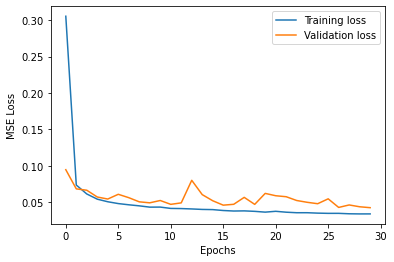

In [18]:
# Show training losses
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

del dl_train, dl_val, training_ds, validation_ds
torch.cuda.empty_cache()

### Use 15 years of data

In [19]:
train_years = ('1997', '2012')#('1979', '2012')
val_years = ('2013', '2016')
test_years = ('2017', '2018')


#### Define functions

#### Load data

In [20]:
# z500, t850, orog, lats, lsm, slt, rad
#feature_idx = [0, 1]
ds = xr.merge([z500, t850, rad], compat='override')
#ds = xr.merge([z500, t850, orog, lats, lsm, slt, rad], compat='override')

ds_train = ds.sel(time=slice(*train_years))
ds_valid = ds.sel(time=slice(*val_years))
ds_test = ds.sel(time=slice(*test_years))


#### Define model parameters

In [21]:
# Train and validation data
training_ds = WeatherBenchDatasetXarrayHealpixTemp(ds=ds_train, out_features=out_features, delta_t=delta_t,
                                                   len_sqce=len_sqce, max_lead_time=max_lead_time,
                                                   years=train_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                   mean=train_mean_, std=train_std_, load=False)
validation_ds = WeatherBenchDatasetXarrayHealpixTemp(ds=ds_valid, out_features=out_features, delta_t=delta_t,
                                                     len_sqce=len_sqce, max_lead_time=max_lead_time,
                                                     years=val_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                     mean=train_mean_, std=train_std_, load=False)

dl_train = DataLoader(training_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers,\
                      pin_memory=pin_memory)

dl_val = DataLoader(validation_ds, batch_size=batch_size*2, shuffle=False, num_workers=num_workers,\
                    pin_memory=pin_memory)

Loading data to RAM...
Time: 20.78s
Loading data to RAM...
Time: 4.91s


In [22]:
# Model
#spherical_unet = UNetSphericalTempHealpix(N=nodes, len_sqce=len_sqce, in_channels=in_features, out_channels=out_features, graph_width=3)

spherical_unet = UNetSphericalHealpix(N=nodes, in_channels=in_features*len_sqce, out_channels=out_features, kernel_size=3)
spherical_unet, device = init_device(spherical_unet, gpu=gpu)


Train and test. Plot results

In [23]:
# Train model
train_loss, val_loss = train_model_2steps(spherical_unet, device, training_ds, \
                                          constants_tensor.transpose(1,0), batch_size=150, epochs=30, \
                                           lr=learning_rate, validation_ds=validation_ds)


Batch idx: 900; Loss: 0.180Epoch:   1/ 30  - loss: 0.176  - val_loss: 0.07593  - time: 1013.196088
Batch idx: 900; Loss: 0.053Epoch:   2/ 30  - loss: 0.053  - val_loss: 0.05936  - time: 1014.286102
Batch idx: 900; Loss: 0.047Epoch:   3/ 30  - loss: 0.047  - val_loss: 0.07844  - time: 1016.878074
Batch idx: 900; Loss: 0.044Epoch:   4/ 30  - loss: 0.044  - val_loss: 0.05426  - time: 1022.836993
Batch idx: 900; Loss: 0.042Epoch:   5/ 30  - loss: 0.042  - val_loss: 0.08834  - time: 1011.416280
Batch idx: 900; Loss: 0.040Epoch:   6/ 30  - loss: 0.040  - val_loss: 0.05603  - time: 1009.841834
Batch idx: 900; Loss: 0.039Epoch:   7/ 30  - loss: 0.039  - val_loss: 0.04716  - time: 1010.254716
Batch idx: 900; Loss: 0.038Epoch:   8/ 30  - loss: 0.038  - val_loss: 0.04218  - time: 1009.628961
Batch idx: 900; Loss: 0.036Epoch:   9/ 30  - loss: 0.036  - val_loss: 0.05441  - time: 1002.185333
Batch idx: 900; Loss: 0.035Epoch:  10/ 30  - loss: 0.035  - val_loss: 0.04574  - time: 1010.720766
Batch idx:

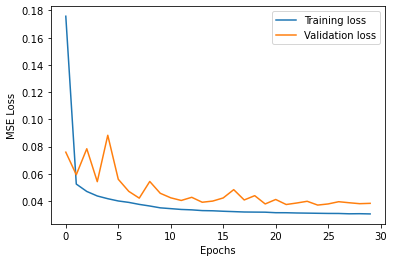

In [24]:
# Show training losses
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

del dl_train, dl_val, training_ds, validation_ds
torch.cuda.empty_cache()

### Use 25 years of data

In [25]:
train_years = ('1987', '2012')#('1979', '2012')
val_years = ('2013', '2016')
test_years = ('2017', '2018')


#### Define functions

#### Load data

In [26]:
# z500, t850, orog, lats, lsm, slt, rad
#feature_idx = [0, 1]
ds = xr.merge([z500, t850, rad], compat='override')
#ds = xr.merge([z500, t850, orog, lats, lsm, slt, rad], compat='override')

ds_train = ds.sel(time=slice(*train_years))
ds_valid = ds.sel(time=slice(*val_years))
ds_test = ds.sel(time=slice(*test_years))


#### Define model parameters

In [27]:
# Train and validation data
training_ds = WeatherBenchDatasetXarrayHealpixTemp(ds=ds_train, out_features=out_features, delta_t=delta_t,
                                                   len_sqce=len_sqce, max_lead_time=max_lead_time,
                                                   years=train_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                   mean=train_mean_, std=train_std_, load=False)
validation_ds = WeatherBenchDatasetXarrayHealpixTemp(ds=ds_valid, out_features=out_features, delta_t=delta_t,
                                                     len_sqce=len_sqce, max_lead_time=max_lead_time,
                                                     years=val_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                     mean=train_mean_, std=train_std_, load=False)

dl_train = DataLoader(training_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers,\
                      pin_memory=pin_memory)

dl_val = DataLoader(validation_ds, batch_size=batch_size*2, shuffle=False, num_workers=num_workers,\
                    pin_memory=pin_memory)

Loading data to RAM...
Time: 33.83s
Loading data to RAM...
Time: 4.31s


In [28]:
# Model
#spherical_unet = UNetSphericalTempHealpix(N=nodes, len_sqce=len_sqce, in_channels=in_features, out_channels=out_features, graph_width=3)

spherical_unet = UNetSphericalHealpix(N=nodes, in_channels=in_features*len_sqce, out_channels=out_features, kernel_size=3)
spherical_unet, device = init_device(spherical_unet, gpu=gpu)


Train and test. Plot results

In [29]:
# Train model
train_loss, val_loss = train_model_2steps(spherical_unet, device, training_ds, constants_tensor.transpose(1,0), batch_size=100, epochs=15, \
                                           lr=learning_rate, validation_ds=validation_ds)


Batch idx: 2250; Loss: 0.103Epoch:   1/ 15  - loss: 0.102  - val_loss: 0.05662  - time: 1449.496799
Batch idx: 2250; Loss: 0.046Epoch:   2/ 15  - loss: 0.046  - val_loss: 0.06153  - time: 1447.978265
Batch idx: 2250; Loss: 0.040Epoch:   3/ 15  - loss: 0.040  - val_loss: 0.06191  - time: 1447.315451
Batch idx: 2250; Loss: 0.037Epoch:   4/ 15  - loss: 0.037  - val_loss: 0.04623  - time: 1447.489559
Batch idx: 2250; Loss: 0.036Epoch:   5/ 15  - loss: 0.036  - val_loss: 0.05389  - time: 1448.982391
Batch idx: 2250; Loss: 0.034Epoch:   6/ 15  - loss: 0.034  - val_loss: 0.04010  - time: 1449.442725
Batch idx: 2250; Loss: 0.034Epoch:   7/ 15  - loss: 0.034  - val_loss: 0.04049  - time: 1450.100492
Batch idx: 2250; Loss: 0.033Epoch:   8/ 15  - loss: 0.033  - val_loss: 0.03850  - time: 1450.498501
Batch idx: 2250; Loss: 0.033Epoch:   9/ 15  - loss: 0.033  - val_loss: 0.04047  - time: 1447.825625
Batch idx: 2250; Loss: 0.033Epoch:  10/ 15  - loss: 0.033  - val_loss: 0.04217  - time: 1447.785420


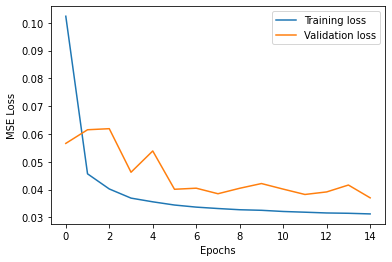

In [30]:
# Show training losses
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

del dl_train, dl_val, training_ds, validation_ds
torch.cuda.empty_cache()